In [1]:
import re
import sys
from time import time, sleep
from pprint import pprint
from functools import partial
from multiprocessing import Pool

import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt

FILENAME = "main.cpp"

In [2]:
!cp ../answer/main.cpp ./{FILENAME}

In [3]:
#!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -DONLINE_JUDGE -o {FILENAME}.out
!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -o {FILENAME}.out

main.cpp:49: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
   49 | #pragma clang attribute push (__attribute__((target("arch=skylake"))),apply_to=function)
      | 
main.cpp:1555: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
 1555 | #pragma clang attribute pop
      | 
main.cpp: In function ‘void globals::UpdateValueTable()’:
main.cpp:860:15: warning: unused variable ‘vm’ [-Wunused-variable]
  860 |   const auto& vm = v_modified[idx_RCSEV];
      |               ^~
main.cpp: In function ‘double beam_width_control::Schedule(const double&)’:
main.cpp:1248:38: warning: unused parameter ‘t’ [-Wunused-parameter]
 1248 | inline double Schedule(const double& t) {
      |                        ~~~~~~~~~~~~~~^
main.cpp: In function ‘void Solve()’:
main.cpp:1424:72: warning: missing initializer for member ‘Solve()::Node::action’ [-Wmissing-field-initializers]
 1424 |   node_buffer.push({ state_buffer[0].score, nullptr, &state_buffer[0] });
      |               

In [4]:
# テストケース生成
SEED = 1000
N_TESTCASES = 200

!mkdir in
for i in range(N_TESTCASES):
    filename = f"{i:04d}.txt"
    seed = SEED + i
    !python3 ../A/tester/generator.py {seed} > ./in/{filename}
!ls in

0000.txt  0025.txt  0050.txt  0075.txt	0100.txt  0125.txt  0150.txt  0175.txt
0001.txt  0026.txt  0051.txt  0076.txt	0101.txt  0126.txt  0151.txt  0176.txt
0002.txt  0027.txt  0052.txt  0077.txt	0102.txt  0127.txt  0152.txt  0177.txt
0003.txt  0028.txt  0053.txt  0078.txt	0103.txt  0128.txt  0153.txt  0178.txt
0004.txt  0029.txt  0054.txt  0079.txt	0104.txt  0129.txt  0154.txt  0179.txt
0005.txt  0030.txt  0055.txt  0080.txt	0105.txt  0130.txt  0155.txt  0180.txt
0006.txt  0031.txt  0056.txt  0081.txt	0106.txt  0131.txt  0156.txt  0181.txt
0007.txt  0032.txt  0057.txt  0082.txt	0107.txt  0132.txt  0157.txt  0182.txt
0008.txt  0033.txt  0058.txt  0083.txt	0108.txt  0133.txt  0158.txt  0183.txt
0009.txt  0034.txt  0059.txt  0084.txt	0109.txt  0134.txt  0159.txt  0184.txt
0010.txt  0035.txt  0060.txt  0085.txt	0110.txt  0135.txt  0160.txt  0185.txt
0011.txt  0036.txt  0061.txt  0086.txt	0111.txt  0136.txt  0161.txt  0186.txt
0012.txt  0037.txt  0062.txt  0087.txt	0112.txt  0137.txt  0162.

In [5]:
TESTCASE_DIRECTORY = "./in/"
TESTCASES = [f"{i:04d}.txt" for i in range(N_TESTCASES)]

In [8]:
# もとのスコアの確認

scores = []
times = []

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    !./{FILENAME}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase} 2> /dev/null
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

for i in range(200):
    score, t = parallel(i)
    scores.append(score)
    times.append(t)

# with Pool(15) as p:
#     for score, t in p.map(parallel, range(N_TESTCASES)):
#         scores.append(score)
#         times.append(t)

np.mean(scores) * 50 / 1e6, np.std(scores) * 50 / 1e6

mkdir: cannot create directory ‘out’: File exists
0000 time:1.9297 score:4810532
0001 time:1.9634 score:5293577
0002 time:1.9577 score:4748731
0003 time:1.9331 score:4697029
0004 time:1.9131 score:4504301
0005 time:1.9375 score:5126808
0006 time:1.9619 score:4888306
0007 time:1.8825 score:5342013
0008 time:1.8816 score:5043137
0009 time:1.8856 score:4928426
0010 time:1.9034 score:4312677
0011 time:1.9228 score:5178757
0012 time:1.9914 score:4423914
0013 time:1.9222 score:4881142
0014 time:1.9542 score:5296656
0015 time:1.9216 score:5130407
0016 time:1.9158 score:5148915
0017 time:1.9360 score:4330493
0018 time:1.8321 score:4885407
0019 time:1.9317 score:4453058
0020 time:1.8763 score:5098420
0021 time:1.9116 score:4853527
0022 time:1.8750 score:4831783
0023 time:1.8986 score:4618530
0024 time:1.9928 score:5123763
0025 time:1.9452 score:4770934
0026 time:1.9561 score:4884354
0027 time:1.9307 score:5622642
0028 time:1.9324 score:4810538
0029 time:1.9770 score:5064751
0030 time:1.9274 sco

(244.64568824999998, 16.4397531514299)

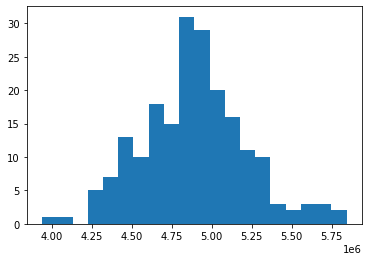

In [9]:
plt.hist(scores, bins=20)
plt.show()

In [10]:
# ここでエラー出力は何かおかしいかもしれない


# パラメータ抽出
with open(FILENAME) as f:
    answer = f.read()


variables_optimize = []

for left, value, right, options in re.findall(r"^([^/\n]*=\s*)(.+?)(\s*;\s*//(?:.*\W)?OPTIMIZE(\W.*))$", answer, re.MULTILINE):
    name = left.replace("=", "").strip().split()[-1]
    
    searched = re.search(r".*\[(?P<min>.*),(?P<max>.*)\].*", options)
    if searched:
        min_value = max_value = None
        try:
            min_value = eval(searched.group("min"))
            max_value = eval(searched.group("max"))
            assert min_value <= max_value
        except Exception as e:
            print(f"searched={searched}", file=sys.stderr)
            print(e, file=sys.stderr)
            continue
        log = "LOG" in options  # 雑、直したほうが良い
        if type(min_value) != type(max_value):
            print(f"searched={searched}", file=sys.stderr)
            print("types not matched", file=sys.stderr)
            continue
        if isinstance(min_value, int):
            method = "suggest_int"
        elif isinstance(min_value, float):
            method = "suggest_float"
        else:
            print(f"searched={searched}", file=sys.stderr)
            print(f"unknown type ({type(min_value)})", file=sys.stderr)
            continue
        variables_optimize.append({
            "name": name,
            "method": method,
            "min": min_value,
            "max": max_value,
            "log": log,
            "left": left,
            "right": right,
        })
    elif searched := re.search(r".*\{(?P<choices>.*?)\}.*", options):
        choices = list(map(lambda x: x.strip(), searched.group("choices").split(",")))
        variables_optimize.append({
            "name": name,
            "method": "suggest_categorical",
            "choices": choices,
            "left": left,
            "right": right,
        })
    else:
        print(f"searched={searched}", file=sys.stderr)
        print(f"pattern was matched but options are incorrect.", file=sys.stderr)

print(len(variables_optimize), "variables were found.")
if globals().get("pd"):
    display(pd.DataFrame(variables_optimize))
else:
    pprint(variables_optimize)

8 variables were found.


,name,method,min,max,log,left,right,choices
0,K_START,suggest_float,0.040,0.120,True,constexpr double K_START =,"; // OPTIMIZE [0.04, 0.12] LOG",NaN
1,K_END,suggest_float,0.030,0.100,True,constexpr double K_END =,"; // OPTIMIZE [0.03, 0.1] LOG",NaN
2,K_H,suggest_float,0.001,0.999,False,constexpr double K_H =,"; // OPTIMIZE [0.001, 0.999]",NaN
3,PURCHASE_TURN_LIMIT,suggest_int,790.000,870.000,False,constexpr short PURCHASE_TURN_LIMIT =,"; // OPTIMIZE [790, 870]",NaN
4,SUBSCORE3_TIGHT_TURN,suggest_int,0.000,1.000,False,constexpr int SUBSCORE3_TIGHT_TURN =,"; // OPTIMIZE [0, 1]",NaN
5,ROUGH_HASH,suggest_categorical,NaN,NaN,NaN,constexpr int ROUGH_HASH =,"; // OPTIMIZE {0, 0b00000001, 0b00010001,...","[0, 0b00000001, 0b00010001, 0b00010011, 0b0011..."
6,TARGET_BEAM_WIDTH_INCREASE_RATE,suggest_float,0.500,1.000,True,constexpr double TARGET_BEAM_WIDTH_INCREASE_RA...,"; // OPTIMIZE [0.5, 1.0] LOG",NaN
7,TARGET_BEAM_WIDTH_HALF_PROGRES_RATE,suggest_float,0.020,0.980,False,constexpr double TARGET_BEAM_WIDTH_HALF_PROGRE...,"; // OPTIMIZE [0.02, 0.98]",NaN


In [11]:
def escape(string):  # 正規表現の中でそのまま使いたい文字列をエスケープ
    res = !echo '{string}' | sed -e 's/[]\/$*.^[]/\\&/g'
    return res[0]

def escape_sed(string):  # sed の置換後の文字列用のエスケープ
    res = !echo '{string}' | sed -e 's/[\/&]/\\&/g'
    return res[0]


def objective_with_index(trial, n_internal_parallel):
    index_parallel = trial.number % 12  # これ変数にする
    print(f"{index_parallel=}")
    
    parameters_changed_filename = f"{index_parallel}_{FILENAME}"
    #directory_input = "./in"  # "/" をつけない  # 中のすべてのファイルに対して実行される
    
    !mkdir {index_parallel}_out 2> /dev/null
    !mkdir {index_parallel}_score 2> /dev/null
    !rm {index_parallel}_out/*
    !rm {index_parallel}_score/*
    
    # ファイル作成
    !cp {FILENAME} {parameters_changed_filename}
    sed_options = [f"-i {parameters_changed_filename}"]
    for variable in variables_optimize:
        if variable["method"] == "suggest_categorical":
            val =  trial.suggest_categorical(variable["name"], variable["choices"])
        else:
            val = getattr(trial, variable["method"])(variable["name"], variable["min"], variable["max"], log=variable["log"])
        left = variable["left"]
        right = variable["right"]
        sed_options.append(f"""-e 's/^{escape(left)}.*{escape(right)}$/{escape_sed(left)}{val}{escape_sed(right)}/'""")
    command_sed = f"sed {' '.join(sed_options)}"
    print(command_sed)
    !{command_sed}
    
    # コンパイル
    command_compile = f"g++ {parameters_changed_filename} -std=gnu++17 -O2 -DONLINE_JUDGE -o {parameters_changed_filename}.out 2> /dev/null"
    print(command_compile)
    !{command_compile}
    
    # 実行・採点コマンド (@ はファイル名)
    command_exec = (
        f"./{parameters_changed_filename}.out < {TESTCASE_DIRECTORY}@ >./{index_parallel}_out/@ 2> /dev/null;"
        f"python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}@ ./{index_parallel}_out/@ > ./{index_parallel}_score/@"
        
        #f"cargo run --release --manifest-path ../tools/Cargo.toml --bin tester {directory_input}/@ $(pwd)/{parameters_changed_filename}.out 2>&1 | grep Score | sed -E s/[^0-9]+// > ./{index_parallel}_score/@;"
        
        #f"./{parameters_changed_filename}.out < {directory_input}/@ > ./{index_parallel}_out/@;"
        #f"cargo run --release --manifest-path ./tools/Cargo.toml --bin vis {directory_input}/@ ./{index_parallel}_out/@ 2> /dev/null > ./{index_parallel}_score/@;"
    )
    
    # 並列実行 (sed はパスのディレクトリ部分を消してファイル名にしてる)
    !find {TESTCASE_DIRECTORY}/* | sed 's!^.*/!!' | xargs -I@ -P {n_internal_parallel} sh -c '{command_exec}'
    
    # 集計
    file_paths = !find ./{index_parallel}_score/*
    sum_score = 0
    for file_path in file_paths:  
        with open(file_path) as f:
            sum_score += int(f.read().split(":")[-1])
    return sum_score

In [13]:
storage_path = f"study.db"
storage = f"sqlite:///{storage_path}"
study_name = "study"
study = optuna.create_study(storage=storage, load_if_exists=True, study_name=study_name, direction="maximize")

def callback(study, trial):
    try:
        if study.best_value == trial.value:
            print(f"Updated! {study.best_value}")
            index_parallel = trial.number % 12
            parameters_changed_filename = f"{index_parallel}_{FILENAME}"
            !cp {parameters_changed_filename} 00000optimized.cpp
        print("callback ok")
    except:
        print(":(")

objective = partial(objective_with_index, n_internal_parallel=4)
study.optimize(objective, n_trials=3000, timeout=86400, n_jobs=4, callbacks=[callback])

[I 2021-09-10 18:28:13,804] A new study created in RDB with name: study


index_parallel=1
index_parallel=0
index_parallel=2
index_parallel=3


/home/nagis/anaconda3/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(


rm: cannot remove '0_out/*': No such file or directory
rm: cannot remove '1_out/*': No such file or directory
rm: cannot remove '2_out/*': No such file or directory
rm: cannot remove '3_out/*': No such file or directory
rm: cannot remove '1_score/*': No such file or directory
rm: cannot remove '0_score/*': No such file or directory
rm: cannot remove '2_score/*': No such file or directory
rm: cannot remove '3_score/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.041305730607641915;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.043533106491330534;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.056602315841052096;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[79

[I 2021-09-10 18:30:50,645] Trial 2 finished with value: 911790583.0 and parameters: {'K_START': 0.058768198691161004, 'K_END': 0.03327028031617907, 'K_H': 0.5043188137343065, 'PURCHASE_TURN_LIMIT': 843, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9981445327421956, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5915574833550853}. Best is trial 2 with value: 911790583.0.


Updated! 911790583.0
callback ok
index_parallel=4
rm: cannot remove '4_out/*': No such file or directory
rm: cannot remove '4_score/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.0664400430302113;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07487932196634334;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6302544546319248;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b0000

[I 2021-09-10 18:30:54,968] Trial 3 finished with value: 907824184.0 and parameters: {'K_START': 0.04763818543849859, 'K_END': 0.08822125325592876, 'K_H': 0.6522267958639705, 'PURCHASE_TURN_LIMIT': 861, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5936963113616759, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9122767819964974}. Best is trial 2 with value: 911790583.0.


callback ok
index_parallel=5
rm: cannot remove '5_out/*': No such file or directory
rm: cannot remove '5_score/*': No such file or directory


[I 2021-09-10 18:30:55,753] Trial 1 finished with value: 878021943.0 and parameters: {'K_START': 0.041305730607641915, 'K_END': 0.043533106491330534, 'K_H': 0.056602315841052096, 'PURCHASE_TURN_LIMIT': 796, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5012251893762257, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.08691553924079493}. Best is trial 2 with value: 911790583.0.


callback ok
index_parallel=6
rm: cannot remove '6_out/*': No such file or directory
rm: cannot remove '6_score/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10245600133790798;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07856663571694536;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7537456880303799;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 18:30:59,154] Trial 0 finished with value: 913902276.0 and parameters: {'K_START': 0.05981993828383682, 'K_END': 0.043919814926183305, 'K_H': 0.4859513797331563, 'PURCHASE_TURN_LIMIT': 867, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5728170370129045, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.40827214918465227}. Best is trial 0 with value: 913902276.0.


Updated! 913902276.0
callback ok
index_parallel=7
rm: cannot remove '7_out/*': No such file or directory
rm: cannot remove '7_score/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10594550851508266;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03441999913431249;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9072715873026584;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 820;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b000

[I 2021-09-10 18:33:28,244] Trial 4 finished with value: 916065475.0 and parameters: {'K_START': 0.0664400430302113, 'K_END': 0.07487932196634334, 'K_H': 0.6302544546319248, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6761928037353611, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4065874707277774}. Best is trial 4 with value: 916065475.0.


Updated! 916065475.0
callback ok
index_parallel=8
rm: cannot remove '8_out/*': No such file or directory
rm: cannot remove '8_score/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.04014365069581348;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053866441029779076;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.16365564400415758;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 818;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b0

[I 2021-09-10 18:33:34,443] Trial 7 finished with value: 890644079.0 and parameters: {'K_START': 0.10594550851508266, 'K_END': 0.03441999913431249, 'K_H': 0.9072715873026584, 'PURCHASE_TURN_LIMIT': 820, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5438111220944172, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7480464180218874}. Best is trial 4 with value: 916065475.0.


callback ok
index_parallel=9
rm: cannot remove '9_out/*': No such file or directory
rm: cannot remove '9_score/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.05576192392024481;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07540811307417815;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.09315073257584991;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 793;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 18:33:36,951] Trial 6 finished with value: 886301132.0 and parameters: {'K_START': 0.061815897117754454, 'K_END': 0.08360678423907666, 'K_H': 0.7368830094171842, 'PURCHASE_TURN_LIMIT': 790, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8676728002617882, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7987252804908413}. Best is trial 4 with value: 916065475.0.


callback ok
index_parallel=10
rm: cannot remove '10_out/*': No such file or directory
rm: cannot remove '10_score/*': No such file or directory
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.04629845843561457;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07848253087568105;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.22311031435408413;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 854;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b0001000

[I 2021-09-10 18:33:39,263] Trial 5 finished with value: 605864550.0 and parameters: {'K_START': 0.10245600133790798, 'K_END': 0.07856663571694536, 'K_H': 0.7537456880303799, 'PURCHASE_TURN_LIMIT': 827, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7795118178505634, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.38929777086699807}. Best is trial 4 with value: 916065475.0.


callback ok
index_parallel=11
rm: cannot remove '11_out/*': No such file or directory
rm: cannot remove '11_score/*': No such file or directory
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.04363847648828177;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.061757591781950394;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7221427615272192;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 870;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b0001000

[I 2021-09-10 18:36:03,580] Trial 8 finished with value: 909700809.0 and parameters: {'K_START': 0.04014365069581348, 'K_END': 0.053866441029779076, 'K_H': 0.16365564400415758, 'PURCHASE_TURN_LIMIT': 818, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5920051156327495, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.12129225650583546}. Best is trial 4 with value: 916065475.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10725492476834414;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.036871765284667804;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.75628113723779;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 801;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 18:36:18,203] Trial 9 finished with value: 886508274.0 and parameters: {'K_START': 0.05576192392024481, 'K_END': 0.07540811307417815, 'K_H': 0.09315073257584991, 'PURCHASE_TURN_LIMIT': 793, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5188869179451439, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.21002659775074006}. Best is trial 4 with value: 916065475.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.08442081141117429;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06496567758866349;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.31603109538530005;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 848;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 18:36:22,171] Trial 10 finished with value: 919845333.0 and parameters: {'K_START': 0.04629845843561457, 'K_END': 0.07848253087568105, 'K_H': 0.22311031435408413, 'PURCHASE_TURN_LIMIT': 854, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7526295343404279, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.05665981704466094}. Best is trial 10 with value: 919845333.0.


Updated! 919845333.0


[I 2021-09-10 18:36:22,237] Trial 11 finished with value: 907871527.0 and parameters: {'K_START': 0.04363847648828177, 'K_END': 0.061757591781950394, 'K_H': 0.7221427615272192, 'PURCHASE_TURN_LIMIT': 870, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5519213453586665, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.276282396400426}. Best is trial 10 with value: 919845333.0.


callback ok
index_parallel=2
callback ok
index_parallel=3
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.07631722304180198;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0663931111933397;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2953088881973239;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 846;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0,

[I 2021-09-10 18:38:37,398] Trial 12 finished with value: 889573896.0 and parameters: {'K_START': 0.10725492476834414, 'K_END': 0.036871765284667804, 'K_H': 0.75628113723779, 'PURCHASE_TURN_LIMIT': 801, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5154094460092901, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.04935634244649073}. Best is trial 10 with value: 919845333.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.08205405554504759;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06468445836281003;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2725455968496849;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 847;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 18:38:54,835] Trial 13 finished with value: 922895853.0 and parameters: {'K_START': 0.08442081141117429, 'K_END': 0.06496567758866349, 'K_H': 0.31603109538530005, 'PURCHASE_TURN_LIMIT': 848, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6802593868682695, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5281451826055159}. Best is trial 13 with value: 922895853.0.


Updated! 922895853.0
callback ok
index_parallel=5


[I 2021-09-10 18:38:55,077] Trial 15 finished with value: 589385145.0 and parameters: {'K_START': 0.08059536710663817, 'K_END': 0.09839020770752036, 'K_H': 0.3059696079615228, 'PURCHASE_TURN_LIMIT': 850, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6853002658113408, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5473360472391989}. Best is trial 13 with value: 922895853.0.


callback ok
index_parallel=6
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.08117094091174024;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.062443254398703046;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.28873134898234787;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 855;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 18:38:57,103] Trial 14 finished with value: 916074181.0 and parameters: {'K_START': 0.07631722304180198, 'K_END': 0.0663931111933397, 'K_H': 0.2953088881973239, 'PURCHASE_TURN_LIMIT': 846, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6773048951104631, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6084295547163354}. Best is trial 13 with value: 922895853.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.0876854289612933;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05383934688828993;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.27728686738785846;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 855;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 18:41:03,150] Trial 16 finished with value: 923009179.0 and parameters: {'K_START': 0.08205405554504759, 'K_END': 0.06468445836281003, 'K_H': 0.2725455968496849, 'PURCHASE_TURN_LIMIT': 847, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7024817519315422, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5629668312501624}. Best is trial 16 with value: 923009179.0.


Updated! 923009179.0
callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.09023100230828217;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05375799043278586;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.40451429032052605;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b000

[I 2021-09-10 18:41:23,892] Trial 17 finished with value: 915434323.0 and parameters: {'K_START': 0.08117094091174024, 'K_END': 0.062443254398703046, 'K_H': 0.28873134898234787, 'PURCHASE_TURN_LIMIT': 855, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7721119461416561, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.703787740660042}. Best is trial 16 with value: 923009179.0.


callback ok
index_parallel=9


[I 2021-09-10 18:41:25,114] Trial 18 finished with value: 914349284.0 and parameters: {'K_START': 0.08129364566718755, 'K_END': 0.06077950217054693, 'K_H': 0.28256548877705695, 'PURCHASE_TURN_LIMIT': 854, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7662936978484985, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6684247286124952}. Best is trial 16 with value: 923009179.0.


callback ok
index_parallel=10
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.09200911501071843;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052056548320589584;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4380428150205574;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 18:41:25,530] Trial 19 finished with value: 925997981.0 and parameters: {'K_START': 0.0876854289612933, 'K_END': 0.05383934688828993, 'K_H': 0.27728686738785846, 'PURCHASE_TURN_LIMIT': 855, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7697936277984325, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.692795205506115}. Best is trial 19 with value: 925997981.0.


Updated! 925997981.0
callback ok
index_parallel=11
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.09359040658071825;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05215591098360091;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4452481512626669;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00

[I 2021-09-10 18:43:33,557] Trial 20 finished with value: 923351392.0 and parameters: {'K_START': 0.09023100230828217, 'K_END': 0.05375799043278586, 'K_H': 0.40451429032052605, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6324726853400247, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7086217675088395}. Best is trial 19 with value: 925997981.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.09311953213353381;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05148160618033992;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.40939985916924276;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 18:43:49,795] Trial 22 finished with value: 929702698.0 and parameters: {'K_START': 0.09359040658071825, 'K_END': 0.05215591098360091, 'K_H': 0.4452481512626669, 'PURCHASE_TURN_LIMIT': 833, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.863813969036641, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8806637204810687}. Best is trial 22 with value: 929702698.0.


Updated! 929702698.0
callback ok
index_parallel=1


[I 2021-09-10 18:43:51,151] Trial 21 finished with value: 922293639.0 and parameters: {'K_START': 0.09200911501071843, 'K_END': 0.052056548320589584, 'K_H': 0.4380428150205574, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6189099806873162, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46620703743628555}. Best is trial 22 with value: 929702698.0.


callback ok
index_parallel=2
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.09711739180027149;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05006481166789455;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4166548997385032;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 18:43:55,223] Trial 23 finished with value: 932572724.0 and parameters: {'K_START': 0.09421179946140373, 'K_END': 0.05232676430361324, 'K_H': 0.44762382083568963, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8818976435223157, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9453202657027664}. Best is trial 23 with value: 932572724.0.


Updated! 932572724.0
callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.09737031418462054;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04618692250975887;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5656708850950667;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 825;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b0000

[I 2021-09-10 18:46:02,010] Trial 24 finished with value: 926387518.0 and parameters: {'K_START': 0.09311953213353381, 'K_END': 0.05148160618033992, 'K_H': 0.40939985916924276, 'PURCHASE_TURN_LIMIT': 832, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6350517991915725, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8690789191646469}. Best is trial 23 with value: 932572724.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11846711950800455;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0470687489350124;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5643953146874439;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 811;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 18:46:12,556] Trial 26 finished with value: 415333394.0 and parameters: {'K_START': 0.11904615663911276, 'K_END': 0.04810585813522847, 'K_H': 0.4097883246115118, 'PURCHASE_TURN_LIMIT': 810, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8603014733699329, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9683890732259488}. Best is trial 23 with value: 932572724.0.


callback ok
index_parallel=5


[I 2021-09-10 18:46:13,628] Trial 25 finished with value: 924027414.0 and parameters: {'K_START': 0.09711739180027149, 'K_END': 0.05006481166789455, 'K_H': 0.4166548997385032, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8560254217105995, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9741205257358969}. Best is trial 23 with value: 932572724.0.


callback ok
index_parallel=6
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.07242570520844145;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04034637945908039;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5733929048401551;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 18:46:20,015] Trial 27 finished with value: 922368289.0 and parameters: {'K_START': 0.09737031418462054, 'K_END': 0.04618692250975887, 'K_H': 0.5656708850950667, 'PURCHASE_TURN_LIMIT': 825, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8847190498469488, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9613236212618037}. Best is trial 23 with value: 932572724.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.07150048504454183;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03799353849558404;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5397495574089064;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 18:48:23,620] Trial 28 finished with value: 908937339.0 and parameters: {'K_START': 0.11846711950800455, 'K_END': 0.0470687489350124, 'K_H': 0.5643953146874439, 'PURCHASE_TURN_LIMIT': 811, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8814568368152516, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9191195558075723}. Best is trial 23 with value: 932572724.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.07241997628445512;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04073053034918122;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5226234479969529;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 18:48:41,607] Trial 29 finished with value: 924965930.0 and parameters: {'K_START': 0.07242570520844145, 'K_END': 0.04034637945908039, 'K_H': 0.5733929048401551, 'PURCHASE_TURN_LIMIT': 827, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9923541570965039, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8338140901242072}. Best is trial 23 with value: 932572724.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.06975705336225045;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04028435231857665;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.47223494160526575;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 18:48:45,671] Trial 30 finished with value: 918929742.0 and parameters: {'K_START': 0.07281125385017978, 'K_END': 0.038832753008488326, 'K_H': 0.5907047636374706, 'PURCHASE_TURN_LIMIT': 826, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9600959888089762, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8589469822925665}. Best is trial 23 with value: 932572724.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.08949451106677732;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.058892224335395316;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4905795419037766;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 18:48:52,176] Trial 31 finished with value: 923885017.0 and parameters: {'K_START': 0.07150048504454183, 'K_END': 0.03799353849558404, 'K_H': 0.5397495574089064, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9610859792881306, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.849476674615375}. Best is trial 23 with value: 932572724.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.08880374261727193;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.057673381671560706;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.36978580110638426;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001,

[I 2021-09-10 18:50:53,068] Trial 32 finished with value: 926530049.0 and parameters: {'K_START': 0.07241997628445512, 'K_END': 0.04073053034918122, 'K_H': 0.5226234479969529, 'PURCHASE_TURN_LIMIT': 830, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9893964292202292, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8346828639803079}. Best is trial 23 with value: 932572724.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.1115449462897484;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04138332419360275;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4808551298357958;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 18:51:11,666] Trial 33 finished with value: 930814893.0 and parameters: {'K_START': 0.06975705336225045, 'K_END': 0.04028435231857665, 'K_H': 0.47223494160526575, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9274379779427642, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8286841624540467}. Best is trial 23 with value: 932572724.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.05309784639152113;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03006863111478901;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4751008137810308;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 18:51:14,936] Trial 34 finished with value: 930069216.0 and parameters: {'K_START': 0.08949451106677732, 'K_END': 0.058892224335395316, 'K_H': 0.4905795419037766, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.804464122956754, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7751490161980934}. Best is trial 23 with value: 932572724.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.0661850399227555;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.030994250990986037;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.46409786794843033;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 863;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 18:51:21,569] Trial 35 finished with value: 928964743.0 and parameters: {'K_START': 0.08880374261727193, 'K_END': 0.057673381671560706, 'K_H': 0.36978580110638426, 'PURCHASE_TURN_LIMIT': 831, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8167516079759869, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.75754498108144}. Best is trial 23 with value: 932572724.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.05376758922437541;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04381580954185785;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.46433228217287204;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 18:53:23,398] Trial 36 finished with value: 934112205.0 and parameters: {'K_START': 0.1115449462897484, 'K_END': 0.04138332419360275, 'K_H': 0.4808551298357958, 'PURCHASE_TURN_LIMIT': 832, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9291854769894713, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7730679369594836}. Best is trial 36 with value: 934112205.0.


Updated! 934112205.0
callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11170232180863544;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04332057742129054;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.48598957242980945;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b000

[I 2021-09-10 18:53:42,797] Trial 37 finished with value: 910531046.0 and parameters: {'K_START': 0.05309784639152113, 'K_END': 0.03006863111478901, 'K_H': 0.4751008137810308, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9250937208950802, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7924375900491113}. Best is trial 36 with value: 934112205.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11107915677744978;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04498539199921702;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.686567737605291;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 860;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 18:53:47,491] Trial 38 finished with value: 911855541.0 and parameters: {'K_START': 0.0661850399227555, 'K_END': 0.030994250990986037, 'K_H': 0.46409786794843033, 'PURCHASE_TURN_LIMIT': 863, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8149200806018869, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7513800063735537}. Best is trial 36 with value: 934112205.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11270964414077231;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04291365179471128;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6599339961911437;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 18:53:51,684] Trial 39 finished with value: 930977451.0 and parameters: {'K_START': 0.05376758922437541, 'K_END': 0.04381580954185785, 'K_H': 0.46433228217287204, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.926172173907791, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9019707557849408}. Best is trial 36 with value: 934112205.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.050692818178356046;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.043332362682133266;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6750736565621269;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 820;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 18:55:52,836] Trial 40 finished with value: 933628399.0 and parameters: {'K_START': 0.11170232180863544, 'K_END': 0.04332057742129054, 'K_H': 0.48598957242980945, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8218433160128823, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6364350277743603}. Best is trial 36 with value: 934112205.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10946992709235474;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04336235235004741;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.35908979601458274;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 18:56:13,321] Trial 41 finished with value: 923478229.0 and parameters: {'K_START': 0.11107915677744978, 'K_END': 0.04498539199921702, 'K_H': 0.686567737605291, 'PURCHASE_TURN_LIMIT': 860, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8217811329750149, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.657684047229512}. Best is trial 36 with value: 934112205.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.1121415542598538;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04311840445136929;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6290411655571622;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 18:56:17,600] Trial 42 finished with value: 929656870.0 and parameters: {'K_START': 0.11270964414077231, 'K_END': 0.04291365179471128, 'K_H': 0.6599339961911437, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8160154201328379, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6253085150346289}. Best is trial 36 with value: 934112205.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10252049822018304;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03530978889222013;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3587303247918404;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 820;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 18:56:21,597] Trial 43 finished with value: 918262030.0 and parameters: {'K_START': 0.050692818178356046, 'K_END': 0.043332362682133266, 'K_H': 0.6750736565621269, 'PURCHASE_TURN_LIMIT': 820, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9193649489717296, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9204043518499985}. Best is trial 36 with value: 934112205.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.062230840270304885;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.034766044295408;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6189707320798438;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 18:58:22,751] Trial 44 finished with value: 751893143.0 and parameters: {'K_START': 0.10946992709235474, 'K_END': 0.04336235235004741, 'K_H': 0.35908979601458274, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9148681612810947, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6432254925141816}. Best is trial 36 with value: 934112205.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.05959962639293027;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03276112302869073;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6016734634602604;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 18:58:44,336] Trial 45 finished with value: 930637579.0 and parameters: {'K_START': 0.1121415542598538, 'K_END': 0.04311840445136929, 'K_H': 0.6290411655571622, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9315027988263608, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9157335784510108}. Best is trial 36 with value: 934112205.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10326301794082937;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.034888851886789134;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8503754803076881;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 18:58:46,997] Trial 46 finished with value: 922077654.0 and parameters: {'K_START': 0.10252049822018304, 'K_END': 0.03530978889222013, 'K_H': 0.3587303247918404, 'PURCHASE_TURN_LIMIT': 820, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9160375804118971, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9200730920799352}. Best is trial 36 with value: 934112205.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.06084894191832753;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.033510552665914586;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.844954640847427;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 851;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 18:58:52,231] Trial 47 finished with value: 916273196.0 and parameters: {'K_START': 0.062230840270304885, 'K_END': 0.034766044295408, 'K_H': 0.6189707320798438, 'PURCHASE_TURN_LIMIT': 844, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9114720484625103, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9102355398566985}. Best is trial 36 with value: 934112205.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.05877940194560317;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04123242294594208;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7969989730970639;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 851;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 19:00:51,626] Trial 48 finished with value: 916451502.0 and parameters: {'K_START': 0.05959962639293027, 'K_END': 0.03276112302869073, 'K_H': 0.6016734634602604, 'PURCHASE_TURN_LIMIT': 844, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9471953688441668, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9018082473215625}. Best is trial 36 with value: 934112205.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.09963269129964791;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04073973308596131;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9087128089412191;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 850;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 19:01:14,486] Trial 49 finished with value: 916677284.0 and parameters: {'K_START': 0.10326301794082937, 'K_END': 0.034888851886789134, 'K_H': 0.8503754803076881, 'PURCHASE_TURN_LIMIT': 845, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7349371659965789, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8162365981830143}. Best is trial 36 with value: 934112205.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.05602064014262577;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04081856794351984;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5056125988522088;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 850;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 19:01:16,337] Trial 50 finished with value: 908654737.0 and parameters: {'K_START': 0.06084894191832753, 'K_END': 0.033510552665914586, 'K_H': 0.844954640847427, 'PURCHASE_TURN_LIMIT': 851, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7316805014281841, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8092304398560912}. Best is trial 36 with value: 934112205.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11467386191678472;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04078461190174308;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.48430087418286943;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:01:24,535] Trial 51 finished with value: 927003622.0 and parameters: {'K_START': 0.05877940194560317, 'K_END': 0.04123242294594208, 'K_H': 0.7969989730970639, 'PURCHASE_TURN_LIMIT': 851, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9590995111048783, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.802097252925041}. Best is trial 36 with value: 934112205.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.09874400903818205;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04924152694418259;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5130316980772319;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:03:24,417] Trial 52 finished with value: 927619690.0 and parameters: {'K_START': 0.09963269129964791, 'K_END': 0.04073973308596131, 'K_H': 0.9087128089412191, 'PURCHASE_TURN_LIMIT': 850, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7340361883068809, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7951983255252637}. Best is trial 36 with value: 934112205.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11607534691399721;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03693580998851803;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5012503570637384;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:03:45,120] Trial 53 finished with value: 924873798.0 and parameters: {'K_START': 0.05602064014262577, 'K_END': 0.04081856794351984, 'K_H': 0.5056125988522088, 'PURCHASE_TURN_LIMIT': 850, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.892056686414386, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7364135621960274}. Best is trial 36 with value: 934112205.0.


callback ok
index_parallel=9


[I 2021-09-10 19:03:46,693] Trial 54 finished with value: 935102529.0 and parameters: {'K_START': 0.11467386191678472, 'K_END': 0.04078461190174308, 'K_H': 0.48430087418286943, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8428081206269598, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.736256009025336}. Best is trial 54 with value: 935102529.0.


Updated! 935102529.0
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11341161158216011;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04888338493083914;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5339229905061227;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 19:03:55,774] Trial 55 finished with value: 934126708.0 and parameters: {'K_START': 0.09874400903818205, 'K_END': 0.04924152694418259, 'K_H': 0.5130316980772319, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8879951489018485, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.740797392525087}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11630388520344329;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04954299931043448;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5202556287529501;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 19:05:56,582] Trial 56 finished with value: 928050453.0 and parameters: {'K_START': 0.11607534691399721, 'K_END': 0.03693580998851803, 'K_H': 0.5012503570637384, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8451333741649605, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7256422952092862}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10625303278737779;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05666187147608175;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.0280803826707563;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 823;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:06:15,786] Trial 58 finished with value: 281285184.0 and parameters: {'K_START': 0.11614165453751518, 'K_END': 0.03741968648122103, 'K_H': 0.23030841074510175, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8437285967917088, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5810515267060643}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=1


[I 2021-09-10 19:06:16,046] Trial 57 finished with value: 928210071.0 and parameters: {'K_START': 0.11341161158216011, 'K_END': 0.04888338493083914, 'K_H': 0.5339229905061227, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9408589357363284, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4996629787499074}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=2
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10633012602614578;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04554746220195124;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3816173397850413;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:06:25,957] Trial 59 finished with value: 831485100.0 and parameters: {'K_START': 0.11630388520344329, 'K_END': 0.04954299931043448, 'K_H': 0.5202556287529501, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8462477806513498, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5719106527778882}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10533992682603475;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05589765733719616;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.38367704875627123;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:08:18,396] Trial 60 finished with value: 253987237.0 and parameters: {'K_START': 0.10625303278737779, 'K_END': 0.05666187147608175, 'K_H': 0.0280803826707563, 'PURCHASE_TURN_LIMIT': 823, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8387590502818902, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5175260297576976}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.04775849160565849;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04627734459863779;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4571019160573559;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:08:43,177] Trial 62 finished with value: 923300271.0 and parameters: {'K_START': 0.10575435038055979, 'K_END': 0.05601859451604404, 'K_H': 0.988036200805986, 'PURCHASE_TURN_LIMIT': 828, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.791985979448822, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6807085509063817}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.047730778937434895;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04537074138925388;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4620315275049477;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:08:46,508] Trial 61 finished with value: 899089208.0 and parameters: {'K_START': 0.10633012602614578, 'K_END': 0.04554746220195124, 'K_H': 0.3816173397850413, 'PURCHASE_TURN_LIMIT': 829, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7919556480310043, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6809906295382928}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.07782651691837494;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04711396168699229;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.44467767427918786;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 847;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:08:53,787] Trial 63 finished with value: 652256578.0 and parameters: {'K_START': 0.10533992682603475, 'K_END': 0.05589765733719616, 'K_H': 0.38367704875627123, 'PURCHASE_TURN_LIMIT': 833, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7892577026823248, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3571910965583311}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.04521661969514155;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03873256085380784;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4504753781832374;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 846;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:10:48,632] Trial 64 finished with value: 924951146.0 and parameters: {'K_START': 0.04775849160565849, 'K_END': 0.04627734459863779, 'K_H': 0.4571019160573559, 'PURCHASE_TURN_LIMIT': 828, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8919144473576133, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6628383369831119}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.04307623604653705;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.038942936738385524;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.33031935096843107;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 847;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 19:11:12,281] Trial 65 finished with value: 923141684.0 and parameters: {'K_START': 0.047730778937434895, 'K_END': 0.04537074138925388, 'K_H': 0.4620315275049477, 'PURCHASE_TURN_LIMIT': 833, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8820338619499941, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7695279015355171}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.09818679000964654;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03874881998772929;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.33801848261745315;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 846;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:11:17,124] Trial 66 finished with value: 929274491.0 and parameters: {'K_START': 0.07782651691837494, 'K_END': 0.04711396168699229, 'K_H': 0.44467767427918786, 'PURCHASE_TURN_LIMIT': 847, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8955575048577068, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8880600668275466}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.08468122853853367;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03857616858159854;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5404031047129755;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 19:11:26,440] Trial 67 finished with value: 921679156.0 and parameters: {'K_START': 0.04521661969514155, 'K_END': 0.03873256085380784, 'K_H': 0.4504753781832374, 'PURCHASE_TURN_LIMIT': 846, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8928679990998921, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8846454888057713}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.09846550192029904;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05187447388501492;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.33104656551005823;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 19:13:19,627] Trial 68 finished with value: 922266915.0 and parameters: {'K_START': 0.04307623604653705, 'K_END': 0.038942936738385524, 'K_H': 0.33031935096843107, 'PURCHASE_TURN_LIMIT': 847, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.879709130020453, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9500835586291744}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.0851398360225488;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.042120051532476305;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5637356391894794;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:13:42,308] Trial 69 finished with value: 931341772.0 and parameters: {'K_START': 0.09818679000964654, 'K_END': 0.03874881998772929, 'K_H': 0.33801848261745315, 'PURCHASE_TURN_LIMIT': 846, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9845730871736745, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8773348046369308}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.08548600098282008;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05135626824625622;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.12119817060059287;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 858;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:13:47,469] Trial 70 finished with value: 928825119.0 and parameters: {'K_START': 0.08468122853853367, 'K_END': 0.03857616858159854, 'K_H': 0.5404031047129755, 'PURCHASE_TURN_LIMIT': 844, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9870505223291098, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9416447164880402}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.0963743352035753;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.042354500988793564;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.41797211133595935;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:13:56,358] Trial 71 finished with value: 908679407.0 and parameters: {'K_START': 0.09846550192029904, 'K_END': 0.05187447388501492, 'K_H': 0.33104656551005823, 'PURCHASE_TURN_LIMIT': 843, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9840465568060778, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9447220097572847}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.09382091209234714;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04226162215974753;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4189073974523644;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:15:51,990] Trial 72 finished with value: 927433946.0 and parameters: {'K_START': 0.0851398360225488, 'K_END': 0.042120051532476305, 'K_H': 0.5637356391894794, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.97702663021171, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7138511096047131}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.0962301754096167;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.044486249051573716;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4217521696265134;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:16:14,969] Trial 73 finished with value: 927706930.0 and parameters: {'K_START': 0.08548600098282008, 'K_END': 0.05135626824625622, 'K_H': 0.12119817060059287, 'PURCHASE_TURN_LIMIT': 858, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9742496197296197, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7113633177190064}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.09632187033187238;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04429163922111535;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.41845831264698974;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:16:18,680] Trial 74 finished with value: 929502133.0 and parameters: {'K_START': 0.0963743352035753, 'K_END': 0.042354500988793564, 'K_H': 0.41797211133595935, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9586404237575451, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.843907068459891}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.06435615831219382;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04429125932390635;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4784040543312461;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:16:26,062] Trial 75 finished with value: 929162217.0 and parameters: {'K_START': 0.09382091209234714, 'K_END': 0.04226162215974753, 'K_H': 0.4189073974523644, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9646439592728664, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8327278056689478}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.06709006715643195;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.044101830671716837;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.48889935722839184;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 853;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 19:18:21,092] Trial 76 finished with value: 929197609.0 and parameters: {'K_START': 0.0962301754096167, 'K_END': 0.044486249051573716, 'K_H': 0.4217521696265134, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9647251170013762, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8387759528535427}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.06652217238737032;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06934575834215478;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.24356920842996005;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:18:45,641] Trial 77 finished with value: 928185174.0 and parameters: {'K_START': 0.09632187033187238, 'K_END': 0.04429163922111535, 'K_H': 0.41845831264698974, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9410180959285613, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8497725203922646}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.06612483950061963;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03987085923137488;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4878669871757085;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:18:50,372] Trial 79 finished with value: 923177921.0 and parameters: {'K_START': 0.06709006715643195, 'K_END': 0.044101830671716837, 'K_H': 0.48889935722839184, 'PURCHASE_TURN_LIMIT': 853, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9397243905220528, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.86523928580854}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=10


[I 2021-09-10 19:18:51,512] Trial 78 finished with value: 933270933.0 and parameters: {'K_START': 0.06435615831219382, 'K_END': 0.04429125932390635, 'K_H': 0.4784040543312461, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8683707599314083, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8567990699495472}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=11
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10196668864478074;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04818841977382124;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.25759540156594435;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 19:20:42,213] Trial 80 finished with value: 926166687.0 and parameters: {'K_START': 0.06652217238737032, 'K_END': 0.06934575834215478, 'K_H': 0.24356920842996005, 'PURCHASE_TURN_LIMIT': 831, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9406182884126719, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6069228676304375}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.06329288333233447;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.047887879509700394;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4792719331791982;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:21:07,717] Trial 81 finished with value: 924392158.0 and parameters: {'K_START': 0.06612483950061963, 'K_END': 0.03987085923137488, 'K_H': 0.4878669871757085, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8668351021456372, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6090232163283534}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10922465469167537;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03597436656930431;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5562600194319514;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:21:18,061] Trial 82 finished with value: 663129852.0 and parameters: {'K_START': 0.10196668864478074, 'K_END': 0.04818841977382124, 'K_H': 0.25759540156594435, 'PURCHASE_TURN_LIMIT': 831, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8646246346620594, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.17137042018921178}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10952146197728245;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03688043626717467;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.1797095982030723;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:21:21,096] Trial 83 finished with value: 327934377.0 and parameters: {'K_START': 0.1093514573775813, 'K_END': 0.04789363362189248, 'K_H': 0.22929992144598205, 'PURCHASE_TURN_LIMIT': 832, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8655874524030028, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.14374003484205577}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.0555375156067945;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03637021112590452;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5471966380435124;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 19:23:12,915] Trial 84 finished with value: 929887497.0 and parameters: {'K_START': 0.06329288333233447, 'K_END': 0.047887879509700394, 'K_H': 0.4792719331791982, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.869169837633319, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.77611975942279}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.05635260207167774;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.039829279888109706;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5587304773146844;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:23:37,962] Trial 85 finished with value: 930111591.0 and parameters: {'K_START': 0.10922465469167537, 'K_END': 0.03597436656930431, 'K_H': 0.5562600194319514, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9059404119038033, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7791986424346733}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.05609803766916597;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053919334248485856;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3948227314154754;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:23:47,850] Trial 86 finished with value: 319800908.0 and parameters: {'K_START': 0.10952146197728245, 'K_END': 0.03688043626717467, 'K_H': 0.1797095982030723, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8285693474665189, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7732145021054405}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.05690401923431201;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053601166437106745;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5950299656753026;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 848;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:23:52,391] Trial 87 finished with value: 917165427.0 and parameters: {'K_START': 0.0555375156067945, 'K_END': 0.03637021112590452, 'K_H': 0.5471966380435124, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8315360865691663, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.79106103327555}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.05060098545250839;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04134908821385713;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5225799453275424;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 824;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:25:45,457] Trial 88 finished with value: 920563663.0 and parameters: {'K_START': 0.05635260207167774, 'K_END': 0.039829279888109706, 'K_H': 0.5587304773146844, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9127098604377637, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.746214319277581}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.051885021179130485;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05024299238539264;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5881381834015802;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 19:26:08,597] Trial 89 finished with value: 930596688.0 and parameters: {'K_START': 0.05609803766916597, 'K_END': 0.053919334248485856, 'K_H': 0.3948227314154754, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8357513229607972, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9765273035956561}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.07886169120587656;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.050283513463094974;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5164606005336597;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 825;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 19:26:18,971] Trial 90 finished with value: 933511980.0 and parameters: {'K_START': 0.05690401923431201, 'K_END': 0.053601166437106745, 'K_H': 0.5950299656753026, 'PURCHASE_TURN_LIMIT': 848, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9990172313353636, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8216574490853712}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11923669752423938;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.041816702771797665;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5129319733057557;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 824;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 19:26:22,719] Trial 91 finished with value: 922095613.0 and parameters: {'K_START': 0.05060098545250839, 'K_END': 0.04134908821385713, 'K_H': 0.5225799453275424, 'PURCHASE_TURN_LIMIT': 824, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9084870816389456, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8196105374996666}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.05226901565930749;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04656077742217844;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6137736563653386;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 849;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 19:28:16,764] Trial 92 finished with value: 930322015.0 and parameters: {'K_START': 0.051885021179130485, 'K_END': 0.05024299238539264, 'K_H': 0.5881381834015802, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9967086419847563, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8185871183752617}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.05351432023676785;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0924416471931238;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6037396803840142;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 848;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 19:28:37,645] Trial 93 finished with value: 927150861.0 and parameters: {'K_START': 0.07886169120587656, 'K_END': 0.050283513463094974, 'K_H': 0.5164606005336597, 'PURCHASE_TURN_LIMIT': 825, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9079290644198845, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8196008921516794}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10085684182325581;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06035013629169831;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5930618959971635;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 849;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:28:49,054] Trial 94 finished with value: 924273369.0 and parameters: {'K_START': 0.11923669752423938, 'K_END': 0.041816702771797665, 'K_H': 0.5129319733057557, 'PURCHASE_TURN_LIMIT': 824, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9001399479869155, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8725168516096141}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.05285759698984211;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03952696240875507;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6108499950908006;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 849;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:28:53,026] Trial 95 finished with value: 927464075.0 and parameters: {'K_START': 0.05226901565930749, 'K_END': 0.04656077742217844, 'K_H': 0.6137736563653386, 'PURCHASE_TURN_LIMIT': 849, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9221013707435349, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8685149468828506}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10046550251189398;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053830941105378186;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6510305053525861;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:30:48,318] Trial 96 finished with value: 917609896.0 and parameters: {'K_START': 0.05351432023676785, 'K_END': 0.0924416471931238, 'K_H': 0.6037396803840142, 'PURCHASE_TURN_LIMIT': 848, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9524031244006674, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8775849302741464}. Best is trial 54 with value: 935102529.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.05792598725663384;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05848284986325612;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3465866505147656;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:31:09,092] Trial 97 finished with value: 936947048.0 and parameters: {'K_START': 0.10085684182325581, 'K_END': 0.06035013629169831, 'K_H': 0.5930618959971635, 'PURCHASE_TURN_LIMIT': 849, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.876594706702797, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8745026330189716}. Best is trial 97 with value: 936947048.0.


Updated! 936947048.0
callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10055038914007382;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05928387115357059;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5897245317031115;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b0000

[I 2021-09-10 19:31:19,285] Trial 98 finished with value: 923739965.0 and parameters: {'K_START': 0.05285759698984211, 'K_END': 0.03952696240875507, 'K_H': 0.6108499950908006, 'PURCHASE_TURN_LIMIT': 849, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9280762670925607, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8877136581593499}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10131186132490802;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.059457983882404676;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5842645560874561;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:31:22,723] Trial 99 finished with value: 928082115.0 and parameters: {'K_START': 0.10046550251189398, 'K_END': 0.053830941105378186, 'K_H': 0.6510305053525861, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6559906201626369, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8927784491645276}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.09120789337421437;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05952690532565608;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7217170254524596;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 852;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:33:19,860] Trial 100 finished with value: 926871801.0 and parameters: {'K_START': 0.05792598725663384, 'K_END': 0.05848284986325612, 'K_H': 0.3465866505147656, 'PURCHASE_TURN_LIMIT': 845, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8521851530780928, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9035952850195819}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.09172165000145602;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06295052506264702;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5818765129631369;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:33:38,338] Trial 101 finished with value: 928306327.0 and parameters: {'K_START': 0.10055038914007382, 'K_END': 0.05928387115357059, 'K_H': 0.5897245317031115, 'PURCHASE_TURN_LIMIT': 845, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8085885977420243, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8996362003803864}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.103623355162696;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03761905132582035;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4697218766190478;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 856;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 19:33:50,574] Trial 102 finished with value: 929025128.0 and parameters: {'K_START': 0.10131186132490802, 'K_END': 0.059457983882404676, 'K_H': 0.5842645560874561, 'PURCHASE_TURN_LIMIT': 845, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.855538242564023, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9258560995240696}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.07445557073027681;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03758052938233085;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.43375428674033767;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 853;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 19:33:54,367] Trial 103 finished with value: 920914915.0 and parameters: {'K_START': 0.09120789337421437, 'K_END': 0.05952690532565608, 'K_H': 0.7217170254524596, 'PURCHASE_TURN_LIMIT': 852, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8773138133820496, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9339425170201952}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.06288175942504491;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04298344948593605;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4730388241136684;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 857;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 19:35:51,615] Trial 104 finished with value: 930588313.0 and parameters: {'K_START': 0.09172165000145602, 'K_END': 0.06295052506264702, 'K_H': 0.5818765129631369, 'PURCHASE_TURN_LIMIT': 845, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8047731730266093, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9342204366375764}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.06383927089211554;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.043418088498320816;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.46446678970176597;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 856;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 19:36:10,086] Trial 105 finished with value: 921478651.0 and parameters: {'K_START': 0.103623355162696, 'K_END': 0.03761905132582035, 'K_H': 0.4697218766190478, 'PURCHASE_TURN_LIMIT': 856, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9999802848027511, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9251132824252797}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.07521961601673918;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04340388821968591;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.44200852679447483;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:36:22,292] Trial 106 finished with value: 925863049.0 and parameters: {'K_START': 0.07445557073027681, 'K_END': 0.03758052938233085, 'K_H': 0.43375428674033767, 'PURCHASE_TURN_LIMIT': 853, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8818530275025565, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.756382036573995}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.06922003988239149;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05494582775443896;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.498545237116788;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 19:36:27,442] Trial 107 finished with value: 925219664.0 and parameters: {'K_START': 0.06288175942504491, 'K_END': 0.04298344948593605, 'K_H': 0.4730388241136684, 'PURCHASE_TURN_LIMIT': 857, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5514491860790467, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7327745058002303}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11414562891288718;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.055036134069822926;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6476917816696002;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:38:23,578] Trial 108 finished with value: 921687034.0 and parameters: {'K_START': 0.06383927089211554, 'K_END': 0.043418088498320816, 'K_H': 0.46446678970176597, 'PURCHASE_TURN_LIMIT': 856, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9251079306896195, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7291898488503594}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.113727692819392;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05538256225393816;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4953209371329336;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 19:38:37,814] Trial 109 finished with value: 928463557.0 and parameters: {'K_START': 0.07521961601673918, 'K_END': 0.04340388821968591, 'K_H': 0.44200852679447483, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8768930972700247, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7388875167144112}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11547693844298305;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06840181914545955;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5330140856792792;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 802;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:38:52,675] Trial 110 finished with value: 931485873.0 and parameters: {'K_START': 0.06922003988239149, 'K_END': 0.05494582775443896, 'K_H': 0.498545237116788, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.926381841175382, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7280876308839724}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=6


[I 2021-09-10 19:38:53,466] Trial 111 finished with value: 933210391.0 and parameters: {'K_START': 0.11414562891288718, 'K_END': 0.055036134069822926, 'K_H': 0.6476917816696002, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9287674875864286, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8555158687772748}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=7
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.06941912010924024;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052611588035856346;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6815285653378926;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:40:50,396] Trial 112 finished with value: 624803486.0 and parameters: {'K_START': 0.113727692819392, 'K_END': 0.05538256225393816, 'K_H': 0.4953209371329336, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9314227289583817, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8568412149683163}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11453306152895283;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05291859019340682;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6947476665262466;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:41:06,854] Trial 113 finished with value: 394743392.0 and parameters: {'K_START': 0.11547693844298305, 'K_END': 0.06840181914545955, 'K_H': 0.5330140856792792, 'PURCHASE_TURN_LIMIT': 802, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9744053531779515, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.85428655880487}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.06875900230893091;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.061341453671134916;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7114070198818635;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:41:18,839] Trial 114 finished with value: 929544233.0 and parameters: {'K_START': 0.06941912010924024, 'K_END': 0.052611588035856346, 'K_H': 0.6815285653378926, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9758437407891174, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6468855611355374}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=10


[I 2021-09-10 19:41:20,176] Trial 115 finished with value: 933220824.0 and parameters: {'K_START': 0.11336298383155445, 'K_END': 0.05507875184646457, 'K_H': 0.6532000475945218, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9498757062679284, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6914821935849377}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=11
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10762555640077207;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06132616927220034;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6468477514931995;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 19:43:15,701] Trial 116 finished with value: 932389142.0 and parameters: {'K_START': 0.11453306152895283, 'K_END': 0.05291859019340682, 'K_H': 0.6947476665262466, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9758098162321698, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6980848942674571}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11130346307721317;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05483042256368517;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7385505111972577;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:43:35,260] Trial 117 finished with value: 927148317.0 and parameters: {'K_START': 0.06875900230893091, 'K_END': 0.061341453671134916, 'K_H': 0.7114070198818635, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8935855697917036, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7993389468388036}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11132952760912564;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.056638183461722905;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6487907464421597;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:43:44,330] Trial 118 finished with value: 930798471.0 and parameters: {'K_START': 0.10762555640077207, 'K_END': 0.06132616927220034, 'K_H': 0.6468477514931995, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8915802550727886, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6863604032508117}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=2


[I 2021-09-10 19:43:45,760] Trial 119 finished with value: 924982322.0 and parameters: {'K_START': 0.10726991324509856, 'K_END': 0.06159869860963105, 'K_H': 0.6411034615860172, 'PURCHASE_TURN_LIMIT': 847, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.897655694906508, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6730760609621115}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=3
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.1110028347307281;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052804082536181664;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7611907349025722;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:45:42,015] Trial 120 finished with value: 924413245.0 and parameters: {'K_START': 0.11130346307721317, 'K_END': 0.05483042256368517, 'K_H': 0.7385505111972577, 'PURCHASE_TURN_LIMIT': 830, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8973577308453319, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6937793628481569}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11730732810153462;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.056895364547404646;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7759671084955658;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:46:01,503] Trial 121 finished with value: 935029104.0 and parameters: {'K_START': 0.11132952760912564, 'K_END': 0.056638183461722905, 'K_H': 0.6487907464421597, 'PURCHASE_TURN_LIMIT': 830, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9481723865989345, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6925535715764308}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11924004378032407;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05781480448880512;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7073176585678806;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:46:10,326] Trial 122 finished with value: 926196593.0 and parameters: {'K_START': 0.1110028347307281, 'K_END': 0.052804082536181664, 'K_H': 0.7611907349025722, 'PURCHASE_TURN_LIMIT': 829, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9460405693844437, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7071535641819298}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=6


[I 2021-09-10 19:46:11,863] Trial 123 finished with value: 928441112.0 and parameters: {'K_START': 0.11245510212641581, 'K_END': 0.052908868281887095, 'K_H': 0.7705568284584229, 'PURCHASE_TURN_LIMIT': 829, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8516949383465571, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7011630907255497}. Best is trial 97 with value: 936947048.0.


sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11946035567218338;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.057239116556981266;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6936586152184556;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/' -e 's

[I 2021-09-10 19:48:07,630] Trial 124 finished with value: 932473743.0 and parameters: {'K_START': 0.11730732810153462, 'K_END': 0.056895364547404646, 'K_H': 0.7759671084955658, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9511524309211334, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7190478613118346}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11786976794190884;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05763372143325851;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6939222458558396;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:48:26,606] Trial 125 finished with value: 928798389.0 and parameters: {'K_START': 0.11924004378032407, 'K_END': 0.05781480448880512, 'K_H': 0.7073176585678806, 'PURCHASE_TURN_LIMIT': 833, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9500716847255433, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6409011837491031}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11663147299852565;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05689431356809626;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6749541059926273;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:48:38,401] Trial 126 finished with value: 923749758.0 and parameters: {'K_START': 0.11946035567218338, 'K_END': 0.057239116556981266, 'K_H': 0.6936586152184556, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9501413029448514, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.628731775521663}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=10


[I 2021-09-10 19:48:39,933] Trial 127 finished with value: 932475758.0 and parameters: {'K_START': 0.11996578204868605, 'K_END': 0.05660708403433551, 'K_H': 0.7023757017349561, 'PURCHASE_TURN_LIMIT': 833, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5883939270723241, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.627961428326921}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=11
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11511388580744075;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05137325178161532;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6632812163336259;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 19:50:34,425] Trial 128 finished with value: 926845177.0 and parameters: {'K_START': 0.11786976794190884, 'K_END': 0.05763372143325851, 'K_H': 0.6939222458558396, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9586718239822962, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6589960735201421}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10392195857007505;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06365916141406432;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7957660924509746;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:50:55,330] Trial 129 finished with value: 932352723.0 and parameters: {'K_START': 0.11663147299852565, 'K_END': 0.05689431356809626, 'K_H': 0.6749541059926273, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9604633274035995, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6331075053758618}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.1087160199852735;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06352899682604077;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7872868544010972;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 19:51:06,008] Trial 130 finished with value: 931489659.0 and parameters: {'K_START': 0.11511388580744075, 'K_END': 0.05137325178161532, 'K_H': 0.6632812163336259, 'PURCHASE_TURN_LIMIT': 832, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6955440901685025, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7578393591911753}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=2


[I 2021-09-10 19:51:07,155] Trial 131 finished with value: 661955317.0 and parameters: {'K_START': 0.11684911980997924, 'K_END': 0.06416437723423847, 'K_H': 0.6668330954113052, 'PURCHASE_TURN_LIMIT': 827, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5774176257375548, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7594136795584957}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=3
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10418011103114692;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0630866429704913;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6444750551929505;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 19:53:02,139] Trial 132 finished with value: 927583466.0 and parameters: {'K_START': 0.10392195857007505, 'K_END': 0.06365916141406432, 'K_H': 0.7957660924509746, 'PURCHASE_TURN_LIMIT': 827, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7456195741010901, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7561657550057741}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11316618741428006;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.056258639013170186;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6327336202562436;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:53:23,485] Trial 133 finished with value: 928674545.0 and parameters: {'K_START': 0.1087160199852735, 'K_END': 0.06352899682604077, 'K_H': 0.7872868544010972, 'PURCHASE_TURN_LIMIT': 827, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5208025897103769, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7661691650063622}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11332900723058346;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.055903921557147566;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6323631346093714;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:53:34,120] Trial 134 finished with value: 930119705.0 and parameters: {'K_START': 0.10418011103114692, 'K_END': 0.0630866429704913, 'K_H': 0.6444750551929505, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5232462832962622, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5462983543360994}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11390302115695417;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05601085052584058;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7458711386666241;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:53:37,423] Trial 135 finished with value: 927703870.0 and parameters: {'K_START': 0.10442475243723792, 'K_END': 0.04939384344782604, 'K_H': 0.8085003133802963, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6589162016132977, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6069315992246435}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11397781535512337;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05420344677458313;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6217952769459715;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:55:28,838] Trial 136 finished with value: 931370670.0 and parameters: {'K_START': 0.11316618741428006, 'K_END': 0.056258639013170186, 'K_H': 0.6327336202562436, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6631878277239263, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5868660720546068}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11068711306617375;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054358471433307555;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.837542397896033;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 19:55:49,429] Trial 137 finished with value: 935246494.0 and parameters: {'K_START': 0.11332900723058346, 'K_END': 0.055903921557147566, 'K_H': 0.6323631346093714, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6680984210999528, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6000640446535205}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11120388862000831;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0541603713322653;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6266051492037881;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-10 19:55:59,882] Trial 138 finished with value: 929170306.0 and parameters: {'K_START': 0.11390302115695417, 'K_END': 0.05601085052584058, 'K_H': 0.7458711386666241, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6226807837419932, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5973252169682401}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.1105837258251293;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06060444180439478;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8324943176772278;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:56:05,160] Trial 139 finished with value: 933272373.0 and parameters: {'K_START': 0.11397781535512337, 'K_END': 0.05420344677458313, 'K_H': 0.6217952769459715, 'PURCHASE_TURN_LIMIT': 832, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9721603546603542, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4698448606305289}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10931212657978638;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05453376993411145;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6127147548641197;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 19:57:55,148] Trial 140 finished with value: 929045909.0 and parameters: {'K_START': 0.11068711306617375, 'K_END': 0.054358471433307555, 'K_H': 0.837542397896033, 'PURCHASE_TURN_LIMIT': 832, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5044999094427652, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6771721793300469}. Best is trial 97 with value: 936947048.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10755464565352929;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.060296207201359836;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6259342046499384;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:58:19,705] Trial 141 finished with value: 939285564.0 and parameters: {'K_START': 0.11120388862000831, 'K_END': 0.0541603713322653, 'K_H': 0.6266051492037881, 'PURCHASE_TURN_LIMIT': 843, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7138068005026054, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6661143348979347}. Best is trial 141 with value: 939285564.0.


Updated! 939285564.0
callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10836149050514345;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05040067084802565;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6166455640619871;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b0000

[I 2021-09-10 19:58:31,005] Trial 142 finished with value: 927821677.0 and parameters: {'K_START': 0.1105837258251293, 'K_END': 0.06060444180439478, 'K_H': 0.8324943176772278, 'PURCHASE_TURN_LIMIT': 843, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5825389733364509, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4861304895052866}. Best is trial 141 with value: 939285564.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10743334311104666;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.050773342728567275;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6225776997371664;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 19:58:34,705] Trial 143 finished with value: 934136807.0 and parameters: {'K_START': 0.10931212657978638, 'K_END': 0.05453376993411145, 'K_H': 0.6127147548641197, 'PURCHASE_TURN_LIMIT': 832, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8719958252991629, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.33283587364438927}. Best is trial 141 with value: 939285564.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10686701195265046;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.050169646691184316;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6235148950134719;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 20:00:23,282] Trial 144 finished with value: 923524019.0 and parameters: {'K_START': 0.10755464565352929, 'K_END': 0.060296207201359836, 'K_H': 0.6259342046499384, 'PURCHASE_TURN_LIMIT': 831, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9373935889967022, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4299394590833288}. Best is trial 141 with value: 939285564.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10655075166809017;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.050477830168623526;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6122469070024132;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 20:00:50,886] Trial 145 finished with value: 930622197.0 and parameters: {'K_START': 0.10836149050514345, 'K_END': 0.05040067084802565, 'K_H': 0.6166455640619871, 'PURCHASE_TURN_LIMIT': 830, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5879343647490073, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4937763627732547}. Best is trial 141 with value: 939285564.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.10555994001247487;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05158109980135089;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5455970765023039;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 20:01:02,126] Trial 146 finished with value: 927371929.0 and parameters: {'K_START': 0.10743334311104666, 'K_END': 0.050773342728567275, 'K_H': 0.6225776997371664, 'PURCHASE_TURN_LIMIT': 831, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7250925300696648, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46186894384389393}. Best is trial 141 with value: 939285564.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11244934405394949;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05484917101925988;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5695863685634603;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-10 20:01:05,728] Trial 147 finished with value: 925450963.0 and parameters: {'K_START': 0.10686701195265046, 'K_END': 0.050169646691184316, 'K_H': 0.6235148950134719, 'PURCHASE_TURN_LIMIT': 831, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.686465049437356, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3309508621261795}. Best is trial 141 with value: 939285564.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.12\] LOG$/constexpr double K_START = 0.11333893656335717;  \/\/ OPTIMIZE [0.04, 0.12] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05376956640247519;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5694223433633996;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 1\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 1]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0


KeyboardInterrupt



In [ ]:
# これビーム実装し忘れてるな？？

In [12]:
!df

Filesystem     1K-blocks    Used Available Use% Mounted on
/dev/root       20145724 7611196  12518144  38% /
devtmpfs         8190004       0   8190004   0% /dev
tmpfs            8193752      32   8193720   1% /dev/shm
tmpfs            1638752     964   1637788   1% /run
tmpfs               5120       0      5120   0% /run/lock
tmpfs            8193752       0   8193752   0% /sys/fs/cgroup
/dev/loop0         56832   56832         0 100% /snap/core18/2128
/dev/loop1        241920  241920         0 100% /snap/google-cloud-sdk/195
/dev/sda15        106858    5321    101537   5% /boot/efi
/dev/loop3        242560  242560         0 100% /snap/google-cloud-sdk/197
/dev/loop2         72064   72064         0 100% /snap/lxd/21029
/dev/loop4         33152   33152         0 100% /snap/snapd/12883
tmpfs            1638748       0   1638748   0% /run/user/1001
